In [1]:
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model_cpu.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop): Dropout(p=0.2)
)

In [3]:
from torch.utils.data import Dataset, DataLoader
from data_load import FacialKeypointsDataset
from torchvision import transforms, utils
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale((250)),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)
batch_size = 16
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [4]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        if(torch.cuda.is_available()):
            images = images.type(torch.cuda.FloatTensor)
        else:
            images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

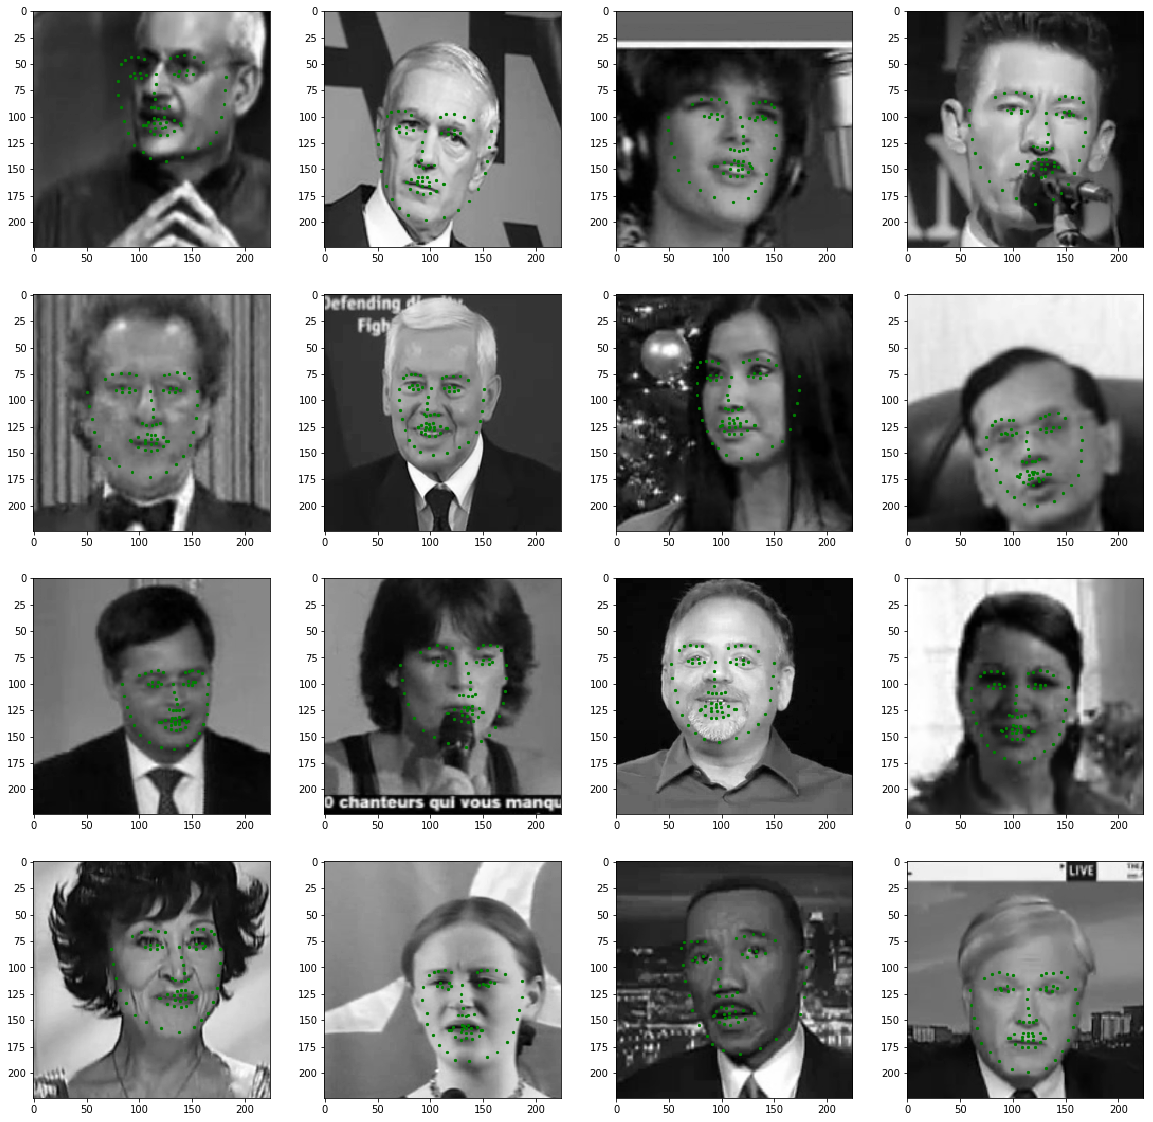

In [5]:
fig, ax = plt.subplots(4,4,figsize=(20,20))
test_images, test_outputs, gt_pts = net_sample_output()
for i in range(16):
    img = test_images[i].data.cpu().numpy()
    img = np.transpose(img,(1,2,0))
    
    predicted_key_pts = test_outputs[i].data.cpu().numpy()*50.0+100
    ground_truth_pts = gt_pts[i]
    ground_truth_pts = ground_truth_pts*50.0+100
    
    ax[i//4][i%4].imshow(np.squeeze(img),cmap = 'gray')
    ax[i//4][i%4].scatter(predicted_key_pts[:,0],predicted_key_pts[:,1],s=20,marker='.',c='g')